# TENSORFLOW DATASET PIPELINE
## Intro

In [1]:
# !pip install tensorflow tensorflow-gpu matplotlib

In [2]:
# bring in some dependancies
import os 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# limit gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

MCSHBP:<br>
data.map<br>
data.cache<br>
data.shuffle<br>
data.batch<br>
data.prefetch<br>
data.zip

# 1.1 images Pipeline

In [4]:
#upload the pics
images = tf.data.Dataset.list_files(os.path.join('data','*.jpg'), shuffle=False)
val_img = tf.data.Dataset.list_files(os.path.join('valid','*.jpg'), shuffle=False)

**tf.data.Dataset** is the TF class for Datasets, <br>
**list_files**( *what to look for* )
we specified: "everything ending with '.jpg' in the folder data"

In [5]:
images.as_numpy_iterator().next()

b'data\\00003da8-520c-11ed-86f7-64bc580216eb.jpg'

now, in images we are keeping the file paths. What we need to do is "converting" the paths in actual pictures (tensors):

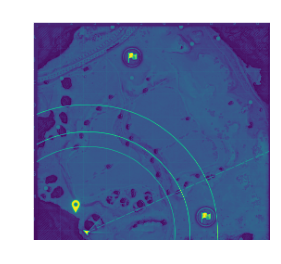

In [6]:
def preprocess(file_path):
    # read the image from path
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.rgb_to_grayscale(img)
    img = img/255
    img = img[80:][:]
    img = tf.image.resize(img, (235,256))
    return img

preprocess(images.as_numpy_iterator().next())
plt.style.use('dark_background')
plt.imshow(preprocess(images.as_numpy_iterator().next()))
plt.title('Example')
plt.show()

do this for every element of the dataset:

In [7]:
images = images.map(preprocess) # map is like lambda functions for tensorflow DS
val_img = val_img.map(preprocess)

# 1.2 Text Pipeline

Now we need to do the same for the text which is our label or target. The plan is:<br>
1. get the content of the .txt files in a way that suits tf.data.Dataset 
2. convert the content in a hot-one encoded label
3. map the function to the dataset

In [8]:
# DEMO FROM STACKOVERFLOW
#dataset = tf.data.Dataset.from_tensor_slices(["a","b","c"])

# def parse(s):
#    return s

#dataset = dataset.map(lambda x: tf.py_function(parse,[x], (tf.string)))

In [9]:
def preprocess_keypress(file_path):
    commands = [0,0,0]
    # 1. get the content
    keypress = tf.io.read_file(file_path)
    keypress = tf.compat.as_str_any(keypress)

    try:
        keypress = keypress.split("\"")[1]
    except:
        return commands
    
    # 2. convert content in hot one encoded labels

    if 'w' in keypress:
        commands[1]+=1
    if 'a' in keypress:
        commands[0]+=1
    if 'd' in keypress:
        commands[2]+=1
    
    return commands

In [10]:
def wrap_array(x1,x2,x3):
    return tf.expand_dims([x1,x2,x3],axis=0)

def unpack_array(y):
    return tf.squeeze(y)

In [11]:
keypress = tf.data.Dataset.list_files(os.path.join('data','*txt'),shuffle=False)
val_keypress = tf.data.Dataset.list_files(os.path.join('valid','*txt'),shuffle=False)
print(keypress.as_numpy_iterator().next())

# 3. map the fucntion to the dataset
keypress = keypress.map(lambda x: tf.py_function(preprocess_keypress, [x], ([tf.int16,tf.int16,tf.int16])))
val_keypress = val_keypress.map(lambda x: tf.py_function(preprocess_keypress, [x], ([tf.int16,tf.int16,tf.int16])))

# make a dataset which is tensor with of the lables 
keypress = keypress.map(wrap_array)
val_keypress = val_keypress.map(wrap_array)

keypress = keypress.map(unpack_array)
val_keypress = val_keypress.map(unpack_array)
print(keypress.as_numpy_iterator().next())

b'data\\00003da8-520c-11ed-86f7-64bc580216eb.txt'
[0 1 1]


## Class imbalance: 
A poisitive bias for 'w' is fine since we want to be moving foward quite often

In [12]:
file_list = []
for fn in os.listdir(os.path.join('data')):
    if fn.endswith('txt'):
        file_list.append(fn)

# examinate 
counter = [0,0,0,0]
for fn in file_list:
    txt = open(os.path.join('data',fn),'r').read()
    if 'w' in txt: counter[0]+=1
    if 'a' in txt: counter[1]+=1
    if 'd' in txt: counter[2]+=1
    if len(txt)==0: counter[3]+=1
print(counter)

[1489, 888, 887, 102]


# 1.3 Combine Pipelines

let s create the dataset, we need to merge the two dataset building pic-txt pairs

In [13]:
dataset = tf.data.Dataset.zip((images, keypress))
valid = tf.data.Dataset.zip((val_img, val_keypress))

[0 1 1]


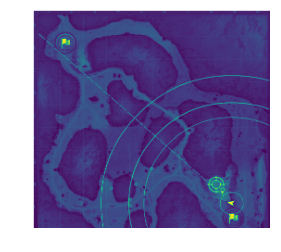

In [14]:
X, y = dataset.shuffle(buffer_size=10000).as_numpy_iterator().next()
plt.imshow(X), print(y)
plt.show()

In [15]:
print("the dataset contains ",len(dataset), " elements")

the dataset contains  2442  elements


In [16]:
dataset = dataset.cache()
dataset = dataset.shuffle(40)
dataset = dataset.batch(40)
dataset = dataset.prefetch(4)

valid = valid.cache()
valid = valid.shuffle(40)
valid = valid.batch(40)
valid = valid.prefetch(4)

In [17]:
X, y = dataset.as_numpy_iterator().next()
print("size of the batch y: ",len(y),"\nsize of the batch X: ",len(X))

size of the batch y:  40 
size of the batch X:  40


In [18]:
X,y = dataset.as_numpy_iterator().next()

# 2. Deep learning stuff

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [20]:
INPUT_SHAPE = images.as_numpy_iterator().next().shape
print(INPUT_SHAPE)

(235, 256, 1)


In [21]:
import tensorflow
model = Sequential()
model.add(Conv2D(64,3, activation='relu', input_shape=INPUT_SHAPE))
model.add(Conv2D(64,3, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 233, 254, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 231, 252, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 3725568)           0         
                                                                 
 dense (Dense)               (None, 64)                238436416 
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 238,474,179
Trainable params: 238,474,179
Non-trainable params: 0
_________________________________________________________________


In [22]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_categorical_accuracy',patience=5)

optim = tf.optimizers.Adam(learning_rate=1e-5)
model.compile(optim, tf.losses.CategoricalCrossentropy(), metrics=["categorical_accuracy"])

In [23]:
history = model.fit(dataset,epochs=70, validation_data=valid,callbacks=[es])

Epoch 1/70
62/62 [==============================] - 10s 127ms/step - loss: 1.4609 - categorical_accuracy: 0.3780 - val_loss: 1.4503 - val_categorical_accuracy: 0.3676
Epoch 2/70
62/62 [==============================] - 5s 77ms/step - loss: 1.4541 - categorical_accuracy: 0.4820 - val_loss: 1.4430 - val_categorical_accuracy: 0.3676
Epoch 3/70
62/62 [==============================] - 5s 78ms/step - loss: 1.4339 - categorical_accuracy: 0.4324 - val_loss: 1.4156 - val_categorical_accuracy: 0.3676
Epoch 4/70
62/62 [==============================] - 5s 77ms/step - loss: 1.3867 - categorical_accuracy: 0.4586 - val_loss: 1.4004 - val_categorical_accuracy: 0.3676
Epoch 5/70
62/62 [==============================] - 5s 78ms/step - loss: 1.3648 - categorical_accuracy: 0.4586 - val_loss: 1.3895 - val_categorical_accuracy: 0.4007
Epoch 6/70
62/62 [==============================] - 5s 78ms/step - loss: 1.3479 - categorical_accuracy: 0.4824 - val_loss: 1.3812 - val_categorical_accuracy: 0.4522
Epoch 7/

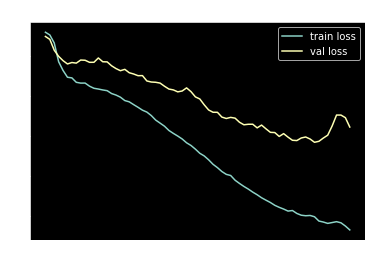

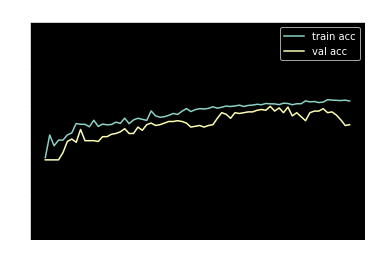

In [24]:
plt.figure()
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.title("TRAING LOSS")
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['categorical_accuracy'],label='train acc')
plt.plot(history.history['val_categorical_accuracy'],label='val acc')
plt.ylim((0,1))
plt.title("TRAING ACCURACY")
plt.xlabel('epochs')
plt.legend()
plt.show()

In [25]:
def round_pred(y, thresh):
    y = np.array(y,dtype='float')
    y[np.where(y>thresh)] = 1
    y = np.array(y, dtype='int')
    return y

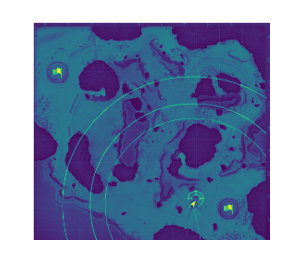

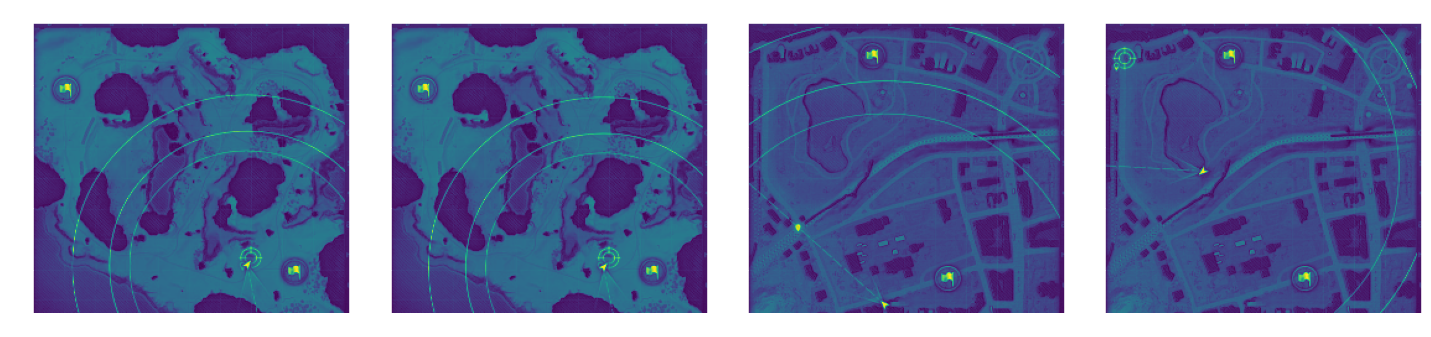

In [40]:

# test 1
x,y = dataset.shuffle(buffer_size=10000).as_numpy_iterator().next()

plt.imshow(x[0])
plt.title('Test pic - original lbl: '+str(y[0]))
plt.xlabel('model prediction: '+str(round_pred(model(x)[0], 0.3)))
plt.show()


fig, ax = plt.subplots(ncols=4, figsize=(20,20))
batch_x,batch_y = valid.shuffle(buffer_size=1000).as_numpy_iterator().next()
for col in range(4):
    ax[col].imshow(x[col])
    ax[col].set_title(round_pred(y[col],0.2))
#fig.suptitle('BATCH PREDICTIONS')
plt.tight_layout()
plt.show()

## SAVE MODEL

In [ ]:
# model.save("WOT_drive_assistant.h5")